In [1]:
import pandas as pd
import numpy as np
import os
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import consts
import utils
from statannotations.Annotator import Annotator
import enhanced_mtdna_dnds_analysis_biopython as mda
import enhanced_sequence_logo_creator as slc
import clean_amb_and_gaps as cag
from ast import literal_eval
# Import reverse complement from Bio
from Bio.Seq import reverse_complement
reload(consts)
reload(utils)
reload(mda)
reload(slc)
reload(cag)
PATH = os.path.dirname(os.getcwd())
UNIVERSAL_OFFSET = 0

# Set the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
NEG_STRAND = ['SHLP1', 'SHLP2', 'SHLP3', 'SHLP4', 'SHLP5', 'GAU']
overlap_df = pd.read_csv(os.path.join(PATH, 'data', 'gene_overlap_positions.csv'))

overlap_df['Gene1'] = overlap_df['Gene1'].str.replace('MT-', '')
overlap_df['Gene2'] = overlap_df['Gene2'].str.replace('MT-', '')

# Load the gene coordinates from hs_row.csv
hs_row = pd.read_parquet(os.path.join(PATH, 'data', 'hs_row.parquet'))
# Convert to series
# Literal eval gene order and gene locations
hs_row = hs_row.iloc[0, :]

REPLACEMENT_DICT = {
    'nad1' : 'ND1', 
    'nad2' : 'ND2',
    'nad3' : 'ND3',
    'nad4' : 'ND4',
    'nad4L' : 'ND4L', 
    'nad5' : 'ND5', 
    'nad6' : 'ND6',
    'cob' : 'CYTB',
    'cox1': 'COX1', 
    'cox2': 'COX2',
    'cox3' : 'COX3',
    'atp6' : 'ATP6', 
    'atp8' : 'ATP8',
}
# Make a dict of lists gene_name:[start, end, strand]
hs_genes = {}
for gene, loc in zip(hs_row['gene_order'], hs_row['gene_locations']):
    loc = loc.split(':')
    try: 
        gene = REPLACEMENT_DICT[gene]
    except KeyError:
        pass
    gene_start = int(loc[0])
    gene_end = int(loc[1])
    gene_strand = loc[2]

    hs_genes[gene] = [gene_start, gene_end, gene_strand]

# Grab ND4L, ND4, ATP8 and ATP6
hs_genes['ND4L_ND4'] = [hs_genes['ND4L'][0], hs_genes['ND4'][1], hs_genes['ND4L'][-1]]
hs_genes['ATP8_ATP6'] = [hs_genes['ATP8'][0], hs_genes['ATP6'][1], hs_genes['ATP8'][-1]]
hs_genes['TS2_TL2_ND5'] = [hs_genes['TRNS2'][0], hs_genes['ND5'][1], hs_genes['TRNS2'][-1]]
 
# Replace nad with ND, cox with CO, cob with CYTB and atp with ATP
overlap_df['overlap_name'] = overlap_df.apply(lambda x : f'{x[0]}_{x[1]}', axis = 1)
# Remove TER from the overlaps
overlap_df = overlap_df[overlap_df['Gene1'] != 'TER']
overlap_df = overlap_df[overlap_df['Gene2'] != 'TER']

co1_overlaps = []
rnr2_overlaps = []
rnr1_overlaps = []
nad4L_overlaps = []
nad4_overlaps = []
atp8_overlaps = []
cyb_overlaps = []
shmoose_overlaps = []
gau_overlaps = []
# Before retrieving the overlap regions, change the overlap coordinates from absolute to relative to the gene/gene pair

for _, row in overlap_df.iterrows():
    gene1 = row['Gene1']
    gene2 = row['Gene2']
    if gene1 == 'RNR2' or gene2 == 'RNR2':
        if gene1 == 'RNR2':
            name = gene2
        else:
            name = gene1
        if name not in NEG_STRAND:
            rnr2_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET -1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])
        else:
            rnr2_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])
    
    if gene1 == 'RNR1' or gene2 == 'RNR1':
        if gene1 == 'RNR1':
            name = gene2
        else:
            name = gene1
        rnr1_overlaps.append([row['Overlap_Start']+ UNIVERSAL_OFFSET-1, row['Overlap_End']+ UNIVERSAL_OFFSET, name])
    
    if gene1 == 'CO1' or gene2 == 'CO1':
        if gene2 == 'GAU' and gene1 == 'CO1':
            name = gene2
            gau_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET -1 , row['Overlap_End'] + UNIVERSAL_OFFSET, name])
        elif gene1 == 'GAU':
            continue
        elif gene1 == 'CO1' and gene2 == 'ALTCO1':
            name = gene2
            co1_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET -1, row['Overlap_End'] + UNIVERSAL_OFFSET+2, name])
   
    if gene1 == 'ALTND4' or gene2 == 'ALTND4':
        if gene1 == 'ALTND4':
            name = gene1
        else:
            name = gene2
        nad4_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET-1, name])
   
    if gene1 == 'ND4L' or gene2 == 'ND4L':
        if gene1 == 'ND4L':
            name = gene2
        else:
            name = gene1
        name = 'Overlap Region'
        nad4L_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])
    
    if gene1 == 'ATP8' or gene2 == 'ATP8':
        if gene1 == 'ATP8':
            name = gene2
        else:
            name = gene1
        name = 'Overlap Region'
        atp8_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])
    
    if gene1 == 'CYB' or gene2 == 'CYB':
        if gene1 == 'CYB':
            name = gene2
        else:
            name = gene1
        cyb_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])

    if gene1 == 'TS2_TL2_ND5':
        name = gene2
        shmoose_overlaps.append([row['Overlap_Start'] + UNIVERSAL_OFFSET-1, row['Overlap_End'] + UNIVERSAL_OFFSET, name])

def abs_to_gene_coords(start, end, gene_start, gene_end, strand):
    if strand == '1' or strand == '+':
        rel_start = int(start - gene_start)
        rel_end = int(end - gene_start)
    else:
        rel_start = int(gene_end - end)
        rel_end = int(gene_end - start)
    return rel_start, rel_end

c:\Users\shtolz\Desktop\multi_function_review\2025_mtdna_overlap_project\bin\utils.py:431: SyntaxWarning: invalid escape sequence '\('
  return re.sub(pattern='\(\w{3}\)',repl = '',string = gene)
c:\Users\shtolz\Desktop\multi_function_review\2025_mtdna_overlap_project\bin\utils.py:440: SyntaxWarning: invalid escape sequence '\D'
  loc = [0 if not checkInt(j) else int(re.sub(string = j, pattern = '\D+', repl = '')) for j in loc]
c:\Users\shtolz\AppData\Local\Programs\Python\Python312\Lib\site-packages\Bio\codonalign\__init__.py:21: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(
C:\Users\shtolz\AppData\Local\Temp\ipykernel_46268\3474887374.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

In [2]:
reload(utils)
# Generate the hs_pop_df dataframe for all analyses:
rnr2_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'RNR2_all.fasta')).set_index('ID').rename(columns = {'sequence' : 'RNR2'})
rnr1_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'RNR1_all.fasta')).set_index('ID').rename(columns = {'sequence' : 'RNR1'})
ATP8_ATP6_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'ATP8_ATP6_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ATP8_ATP6'})
ND4L_ND4_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND4L_ND4_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'ND4L_ND4'})
ND4_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND4_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'ND4'})
CO1_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'COX1_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'COX1'})
CYTB_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'CYTB_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'CYTB'})
TS2_TL2_ND5_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'TRNS2_TRNL2_ND5_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'TS2_TL2_ND5'})
ND4L_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND4L_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ND4L'})
ATP8_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ATP8_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ATP8'})
ATP6_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ATP6_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ATP6'})
# Add all the other canonical genes (ND1, ND2, ND3, ND5, ND6, CO2, CO3)
ND1_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'ND1_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'ND1'})
ND2_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND2_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'ND2'})
ND3_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND3_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'ND3'})
ND5_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'ND5_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ND5'})
ND6_df = utils.fasta_to_df(os.path.join(PATH, 'data', 'per_gene_alignment_fasta', 'ND6_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'ND6'})
CO2_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'COX2_all.fasta'), polya = False).set_index('ID').rename(columns = {'sequence' : 'COX2'})
CO3_df = utils.fasta_to_df(os.path.join(PATH, 'data',  'per_gene_alignment_fasta', 'COX3_all.fasta'), polya = True).set_index('ID').rename(columns = {'sequence' : 'COX3'})

# Add PolyA when necessary

hs_pop_df = pd.concat([rnr2_df, rnr1_df, ATP8_df, ATP6_df, ATP8_ATP6_df, ND4L_ND4_df, ND4_df, ND4L_df, CO1_df, CYTB_df, TS2_TL2_ND5_df, ND1_df, ND2_df, ND3_df, ND5_df, ND6_df, CO2_df, CO3_df], axis=1)
# Drop rows if NA in all columns
hs_pop_df = hs_pop_df.dropna(how='all')
# Replace all float values with NA
hs_pop_df = hs_pop_df.applymap(lambda x: np.nan if isinstance(x, float) else x)
# Make sure that the lenghs of the sequences of each column are all the same
for col in hs_pop_df.columns:
    hs_pop_df_temp = hs_pop_df.dropna(subset = [col])
    seq_lengths = hs_pop_df_temp[col].apply(len)
    assert len(set(seq_lengths)) == 1, f'Sequence lengths in column {col} are not the same! Lengths: {set(seq_lengths)}'
    del hs_pop_df_temp
    
ATP8_end = 207
# Fill NA values in ATP8 using the sequence from ATP8_ATP6
for idx, row in hs_pop_df.iterrows():
    if pd.isna(row['ATP8']):
        atp8_atp6_seq = row['ATP8_ATP6']
        if pd.isna(atp8_atp6_seq):
            continue
        atp8_seq = atp8_atp6_seq[:ATP8_end]
        hs_pop_df.at[idx, 'ATP8'] = atp8_seq
hs_pop_df.to_parquet(os.path.join(PATH, 'data', 'hs_pop_df.parquet'))


Reference sequence (NC_012920.1) expected length: 1670

Reference sequence (NC_012920.1) expected length: 1380

Reference sequence (NC_012920.1) expected length: 1143

Reference sequence (NC_012920.1) expected length: 957

Reference sequence (NC_012920.1) expected length: 1044

Reference sequence (NC_012920.1) expected length: 348

Reference sequence (NC_012920.1) expected length: 786


C:\Users\shtolz\AppData\Local\Temp\ipykernel_46268\2379466956.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hs_pop_df = hs_pop_df.applymap(lambda x: np.nan if isinstance(x, float) else x)


In [3]:
# Convert all overlap coordinates to relative coordinates
print(shmoose_overlaps, hs_genes['TS2_TL2_ND5'])
shmoose_overlaps_rel = abs_to_gene_coords(shmoose_overlaps[0][0], shmoose_overlaps[0][1], hs_genes['TS2_TL2_ND5'][0], hs_genes['TS2_TL2_ND5'][1], hs_genes['TS2_TL2_ND5'][2])
shmoose_overlaps_rel = [shmoose_overlaps[0][-1], shmoose_overlaps_rel[0], shmoose_overlaps_rel[1]]

rnr1_overlaps_rel = []
for overlap in rnr1_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['RNR1'][0], hs_genes['RNR1'][1], hs_genes['RNR1'][2])
    rnr1_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
rnr2_overlaps_rel = []
for overlap in rnr2_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['RNR2'][0], hs_genes['RNR2'][1], hs_genes['RNR2'][2])
    rnr2_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
co1_overlaps_rel = []
for overlap in co1_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['COX1'][0], hs_genes['COX1'][1], hs_genes['COX1'][2])
    co1_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
gau_overlaps_rel = []
for overlap in gau_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['COX1'][0], hs_genes['COX1'][1], hs_genes['COX1'][2])
    gau_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
shmoose_overlaps_rel = []
for overlap in shmoose_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['TS2_TL2_ND5'][0], hs_genes['TS2_TL2_ND5'][1], hs_genes['TS2_TL2_ND5'][2])
    shmoose_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
nad4_overlaps_rel = []
for overlap in nad4_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['ND4'][0], hs_genes['ND4'][1], hs_genes['ND4'][2])
    nad4_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
nad4L_nad4_overlaps_rel = []
for overlap in nad4L_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['ND4L_ND4'][0], hs_genes['ND4L_ND4'][1], hs_genes['ND4L_ND4'][2])
    nad4L_nad4_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
atp8_atp6_overlaps_rel = []
for overlap in atp8_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['ATP8_ATP6'][0], hs_genes['ATP8_ATP6'][1], hs_genes['ATP8_ATP6'][2])
    atp8_atp6_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])
cyb_overlaps_rel = []
for overlap in cyb_overlaps:
    rel_coords = abs_to_gene_coords(overlap[0], overlap[1], hs_genes['CYTB'][0], hs_genes['CYTB'][1], hs_genes['CYTB'][2])
    cyb_overlaps_rel.append([overlap[-1], rel_coords[0], rel_coords[1]])


[[12233, 12410, 'SHMOOSE']] [12206, 14148, '1']


In [4]:
# Save all relative overlap coords nested lists into a json file
import json
overlap_coords_rel_dict = {
    'rnr2_overlaps_rel' : rnr2_overlaps_rel,
    'rnr1_overlaps_rel' : rnr1_overlaps_rel,
    'co1_overlaps_rel' : co1_overlaps_rel,
    'gau_overlaps_rel' : gau_overlaps_rel,
    'shmoose_overlaps_rel' : shmoose_overlaps_rel,
    'nad4_overlaps_rel' : nad4_overlaps_rel,
    'nad4L_nad4_overlaps_rel' : nad4L_nad4_overlaps_rel,
    'atp8_atp6_overlaps_rel' : atp8_atp6_overlaps_rel,
    'cyb_overlaps_rel' : cyb_overlaps_rel
}
with open(os.path.join(PATH, 'data', 'overlap_coords_rel.json'), 'w') as f:
    json.dump(overlap_coords_rel_dict, f, indent=4)



In [5]:
import json
# Save a dict with all the overlaps with absolute positions (rCRS) as a json file
overlaps_dict = {
    'RNR2': rnr2_overlaps,
    'RNR1': rnr1_overlaps,
    'CO1': co1_overlaps,
    'ALTND4': nad4_overlaps,
    'ND4L': nad4L_overlaps,
    'ATP8': atp8_overlaps,
    'CYB': cyb_overlaps,
    'SHMOOSE': shmoose_overlaps,
    'GAU': gau_overlaps
}
json_path = os.path.join(PATH, 'data', 'overlap_coords.json')
with open(json_path, 'w') as f:
    json.dump(overlaps_dict, f, indent=4)
    

In [6]:
hs_pop_df['Hum_seq'] = hs_pop_df.apply(lambda x : x['RNR2'][int(rnr2_overlaps_rel[4][1]):int(rnr2_overlaps_rel[4][2])] if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP3_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['RNR2'][rnr2_overlaps_rel[0][1]:rnr2_overlaps_rel[0][2]]) if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP2_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['RNR2'][rnr2_overlaps_rel[1][1]:rnr2_overlaps_rel[1][2]]) if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP4_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['RNR2'][rnr2_overlaps_rel[2][1]:rnr2_overlaps_rel[2][2]]) if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP1_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['RNR2'][rnr2_overlaps_rel[3][1]:rnr2_overlaps_rel[3][2]]) if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP5_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['RNR2'][rnr2_overlaps_rel[5][1]:rnr2_overlaps_rel[5][2]]) if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['SHLP6_seq'] = hs_pop_df.apply(lambda x : x['RNR2'][rnr2_overlaps_rel[6][1]:rnr2_overlaps_rel[6][2]] if isinstance(x['RNR2'], str) else np.nan, axis = 1)
hs_pop_df['MOTC_seq'] = hs_pop_df.apply(lambda x : x['RNR1'][rnr1_overlaps_rel[0][1]:rnr1_overlaps_rel[0][2]] if isinstance(x['RNR1'], str) else np.nan, axis = 1)
hs_pop_df['GAU_seq'] = hs_pop_df.apply(lambda x : reverse_complement(x['COX1'][gau_overlaps_rel[0][1]:gau_overlaps_rel[0][2]]) if isinstance(x['COX1'], str) else np.nan, axis = 1)
hs_pop_df['shmoose_seq'] = hs_pop_df.apply(lambda x : x['TS2_TL2_ND5'][shmoose_overlaps_rel[0][1]:shmoose_overlaps_rel[0][2]] if isinstance(x['TS2_TL2_ND5'], str) else np.nan, axis = 1)
hs_pop_df['CO1_alt_seq'] = hs_pop_df.apply(lambda x : x['COX1'][co1_overlaps_rel[0][1]:co1_overlaps_rel[0][2]] if isinstance(x['COX1'], str) else np.nan, axis = 1)
hs_pop_df['ND4_alt_seq'] = hs_pop_df.apply(lambda x : x['ND4'][nad4_overlaps_rel[0][1]:nad4_overlaps_rel[0][2]] if isinstance(x['ND4'], str) else np.nan, axis = 1)
hs_pop_df['CYB_alt_seq'] = hs_pop_df.apply(lambda x : x['CYTB'][cyb_overlaps_rel[0][1]:cyb_overlaps_rel[0][2]] if isinstance(x['CYTB'], str) else np.nan, axis = 1)
hs_pop_df['ATP8_6_overlap_seq_upstream'] = hs_pop_df.apply(lambda x : x['ATP8_ATP6'][atp8_atp6_overlaps_rel[0][1] - 2:atp8_atp6_overlaps_rel[0][2]] if isinstance(x['ATP8_ATP6'], str) else np.nan, axis = 1)
hs_pop_df['ATP8_6_overlap_seq_downstream'] = hs_pop_df.apply(lambda x : x['ATP8_ATP6'][atp8_atp6_overlaps_rel[0][1]:atp8_atp6_overlaps_rel[0][2] - 1] if isinstance(x['ATP8_ATP6'], str) else np.nan, axis = 1)
hs_pop_df['ND4L_4_overlap_seq_upstream'] = hs_pop_df.apply(lambda x : x['ND4L_ND4'][nad4L_nad4_overlaps_rel[0][1] - 2:nad4L_nad4_overlaps_rel[0][2]] if isinstance(x['ND4L_ND4'], str) else np.nan, axis = 1)
hs_pop_df['ND4L_4_overlap_seq_downstream'] = hs_pop_df.apply(lambda x : x['ND4L_ND4'][nad4L_nad4_overlaps_rel[0][1]:nad4L_nad4_overlaps_rel[0][2] - 1] if isinstance(x['ND4L_ND4'], str) else np.nan, axis = 1)



hs_pop_df = hs_pop_df.reset_index()
hs_pop_df['ID'] = hs_pop_df['ID'].str.replace('.', '')
hs_pop_df.to_csv(os.path.join(PATH, 'data', 'hs_pop_df_with_overlap_sequences_per_gene.csv'), index=False)

In [7]:
# Save all the overlap sequences as fasta files
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_hu_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["Hum_seq"]}\n')
# Save the SHLP3_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp3_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP3_seq"]}\n')
# Save the SHLP2_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp2_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP2_seq"]}\n')
# Save the SHLP4_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp4_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP4_seq"]}\n')
# Save the SHLP1_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp1_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP1_seq"]}\n')
# Save the SHLP5_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp5_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP5_seq"]}\n')
# Save the SHLP6_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr2_shlp6_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["SHLP6_seq"]}\n')
# Save the shmoose_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'shmoose_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["shmoose_seq"]}\n')
# Save the GAU_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'co1_gau_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["GAU_seq"]}\n')
# Save the MOTC_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'rnr1_motc_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["MOTC_seq"]}\n')
# Save the CO1_alt_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'co1_alt_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["CO1_alt_seq"]}\n')
# Save the ND4_alt_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'nd4_alt_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["ND4_alt_seq"]}\n')
# Save the CYB_alt_seq as a fasta file
with open(os.path.join(PATH, 'data', 'hs_pop_seq', 'cyb_alt_seq.fasta'), 'w') as f:
    for i, row in hs_pop_df.iterrows():
        f.write(f'>{row["ID"]}\n')
        f.write(f'{row["CYB_alt_seq"]}\n')
        

In [8]:
ref_seq_rnr2 = hs_pop_df[hs_pop_df['ID'] == 'NC_0129201']['RNR2'].iloc[0]
ref_seq_rnr1 = hs_pop_df[hs_pop_df['ID'] == 'NC_0129201']['RNR1'].iloc[0]
ref_seq_shlp3 = hs_pop_df[hs_pop_df['ID'] == 'NC_0129201']['SHLP3_seq'].iloc[0]


In [9]:
print(hs_pop_df['SHLP4_seq'].iloc[0])
print(hs_pop_df['SHLP4_seq'].dropna().apply(len).std())
print(rnr2_overlaps_rel)

ATGCTAGAGGTGATGTTTTTGGTAAACAGGCGGGGTAAGATTTGCCGAGTTCCTTTTACTTTTTTTAACCTTTCCTTATGA
0.0
[['SHLP3', 32, 149], ['SHLP2', 417, 498], ['SHLP4', 771, 852], ['SHLP1', 814, 889], ['Hum', 962, 1037], ['SHLP5', 1109, 1184], ['SHLP6', 1319, 1382]]


2026-01-18 21:08:22,223 - INFO - Starting dN/dS analysis for RNR2
2026-01-18 21:08:22,223 - INFO - Using Biopython method: NG86
2026-01-18 21:08:22,224 - INFO - Analyzing 7 micro-protein regions
2026-01-18 21:08:22,224 - INFO - Dataset contains 64933 sequences
2026-01-18 21:08:22,225 - INFO - Within protein mode: False
2026-01-18 21:08:22,227 - WARNING - Column 'RNR2_seq' not found in DataFrame. Using RNR2 as gene sequences.
2026-01-18 21:08:22,227 - INFO - Using provided reference sequence
2026-01-18 21:08:22,228 - WARNING - No reference gene sequence provided, using reference sequence for gene analysis
2026-01-18 21:08:22,228 - INFO - Subsampled from 64933 to 64933 sequences
2026-01-18 21:08:22,229 - INFO - Analyzing micro-protein: Hum (962-1037, strand: +)
2026-01-18 21:08:22,229 - INFO - Using nuclear genetic code for Hum
2026-01-18 21:08:22,230 - INFO - Extracted reference sequence for Hum: ATGGCTCCACGAGGGTTCAGCTGTCTCTTACTTTTAACCAGTGAAATTGACCTGCCCGTGAAGAGGCGGGCATAA
2026-01-18 21:0

Using 64933 sequences for gene RNR2


2026-01-18 21:08:24,342 - INFO - out of 64933 sequences, 64725 were kept after cleaning for Hum
2026-01-18 21:08:24,343 - INFO - out of 25 codon positions, 25 were kept after cleaning for Hum
2026-01-18 21:08:24,346 - INFO - Found 37 unique variants for Hum after filtering
2026-01-18 21:08:24,383 - INFO - Total synonymous sites for Hum: 4.7276391571177205
2026-01-18 21:08:24,383 - INFO - Total non-synonymous sites for Hum: 52.25729711171193
2026-01-18 21:08:24,384 - INFO - Total synonymous differences for Hum: 0.00027206031078478795
2026-01-18 21:08:24,384 - INFO - Total non-synonymous differences for Hum: 0.006580682562272881
2026-01-18 21:08:24,387 - INFO - Synonymous rate for Hum: 0.000058
2026-01-18 21:08:24,388 - INFO - Non-synonymous rate for Hum: 0.000126
2026-01-18 21:08:24,389 - INFO -   dN/dS ratio for Hum: 2.1883
2026-01-18 21:08:24,390 - INFO -   Synonymous rate: 0.000058
2026-01-18 21:08:24,390 - INFO -   Non-synonymous rate: 0.000126
2026-01-18 21:08:24,390 - INFO -   Sta

Hum: MAPRGFSCLLLLTSEIDLPVKRRA*
Genetic code: nuclear
Coordinates adjusted: False
SHLP1: MCHWAGGASNTGDARGDVFGKQAG*
Genetic code: nuclear
Coordinates adjusted: False
SHLP2: MGVKFFTLSTRFFPSVQRAVPLWTNS*
Genetic code: nuclear
Coordinates adjusted: False
SHLP3: MLGYNFSSFPCGTISIAPGFNFYRLYFIWVNGLAKVVW*
Genetic code: nuclear
Coordinates adjusted: False
SHLP4: MLEVMFLVNRRGKICRVPFTFFNLSL*
Genetic code: nuclear
Coordinates adjusted: False
SHLP5: MYCSEVGFCSEVAPTEIFNAGLVV*
Genetic code: nuclear
Coordinates adjusted: False
SHLP6: MLDQDIPMVQPLLKVRLFND*
Genetic code: nuclear
Coordinates adjusted: False


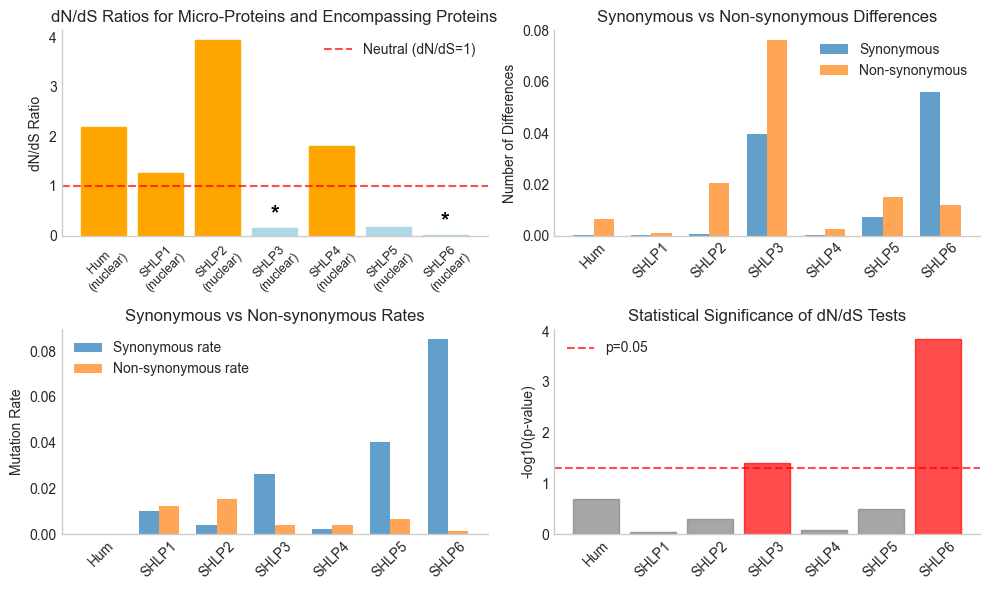

In [10]:
reload(mda)

# For RNR2 analysis
RNR2_MICROPROTEINS = [
    [962, 1037, 'Hum', '+'],
    [814, 889, 'SHLP1', '-'],
    [417, 498, 'SHLP2', '-'],
    [32, 149, 'SHLP3', '-'],
    [771, 852, 'SHLP4', '-'],
    [1109, 1184, 'SHLP5', '-'],
    [1319, 1382, 'SHLP6', '+']
]
# Define which genetic code each micro-protein uses
RNR2_GENETIC_CODES = {
    'Hum': 'nuclear',  # Unknown in literature, translated as nucleus for our purposes
    'SHLP1': 'nuclear',        # Translated in cytoplasm
    'SHLP2': 'nuclear',
    'SHLP3': 'nuclear',
    'SHLP4': 'nuclear',
    'SHLP5': 'nuclear',
    'SHLP6': 'nuclear',
}

# Provide expected sequences for coordinate verification
RNR2_EXPECTED_SEQUENCES = {
}
# Run analysis with new features
results_rnr2 = mda.analyze_microprotein_dnds(
    df=hs_pop_df.dropna(subset=['RNR2']),
    microprotein_regions=RNR2_MICROPROTEINS,
    gene_name='RNR2',
    sequence_column='RNR2',
    expected_sequences=RNR2_EXPECTED_SEQUENCES, 
    genetic_codes=RNR2_GENETIC_CODES,          
    coordinate_search_window=50,                 
    min_coordinate_similarity=0.8,
    reference_sequence=ref_seq_rnr2,
    dnds_method = 'NG86',
    plot_results=True,
    statistical_test = 'z_test_robust',
    output_file=os.path.join(PATH, 'figures', 'rnr2_dnds_analysis.png'),
    min_frequency=1e-5,
    figsize = (10, 6),
    threshold = .05,
    weight_by_frequency = True
    
)


# Access amino acid sequences
for name, mp_result in results_rnr2['microprotein_results'].items():
    print(f"{name}: {mp_result['sequence_info']['amino_acid_sequence']}")
    print(f"Genetic code: {mp_result['sequence_info']['genetic_code']}")
    print(f"Coordinates adjusted: {mp_result['coordinates']['coordinate_adjusted']}")

2026-01-18 21:08:40,381 - INFO - Starting dN/dS analysis for RNR1
2026-01-18 21:08:40,382 - INFO - Using Biopython method: NG86
2026-01-18 21:08:40,383 - INFO - Analyzing 1 micro-protein regions
2026-01-18 21:08:40,384 - INFO - Dataset contains 65719 sequences
2026-01-18 21:08:40,384 - INFO - Within protein mode: False
2026-01-18 21:08:40,387 - WARNING - Column 'RNR1_seq' not found in DataFrame. Using RNR1 as gene sequences.
2026-01-18 21:08:40,388 - INFO - Using provided reference sequence
2026-01-18 21:08:40,388 - WARNING - No reference gene sequence provided, using reference sequence for gene analysis
2026-01-18 21:08:40,389 - INFO - Subsampled from 65719 to 65719 sequences
2026-01-18 21:08:40,389 - INFO - Analyzing micro-protein: MOTSc (695-746, strand: +)
2026-01-18 21:08:40,390 - INFO - Using nuclear genetic code for MOTSc
2026-01-18 21:08:40,390 - INFO - Extracted reference sequence for MOTSc: ATGAGGTGGCAAGAAATGGGCTACATTTTCTACCCCAGAAAACTACGATAG
2026-01-18 21:08:40,390 - INFO - M

Using 65719 sequences for gene RNR1


2026-01-18 21:08:41,803 - INFO - out of 65719 sequences, 65587 were kept after cleaning for MOTSc
2026-01-18 21:08:41,803 - INFO - out of 17 codon positions, 17 were kept after cleaning for MOTSc
2026-01-18 21:08:41,806 - INFO - Found 31 unique variants for MOTSc after filtering
2026-01-18 21:08:41,822 - WARNING - Internal stop codons detected, cannot use Biopython dN/dS calculation. Falling back to custom implementation.
2026-01-18 21:08:41,823 - WARNING - Internal stop codons detected, cannot use Biopython dN/dS calculation. Falling back to custom implementation.
2026-01-18 21:08:41,830 - INFO - Total synonymous sites for MOTSc: 0.028084833884763755
2026-01-18 21:08:41,830 - INFO - Total non-synonymous sites for MOTSc: 0.44935734215622
2026-01-18 21:08:41,830 - INFO - Total synonymous differences for MOTSc: 0.00011152704746225085
2026-01-18 21:08:41,831 - INFO - Total non-synonymous differences for MOTSc: 0.006239252643999916
2026-01-18 21:08:41,831 - INFO - Synonymous rate for MOTSc

MOTSc: MRWQEMGYIFYPRKLR*
Genetic code: nuclear
Coordinates adjusted: False


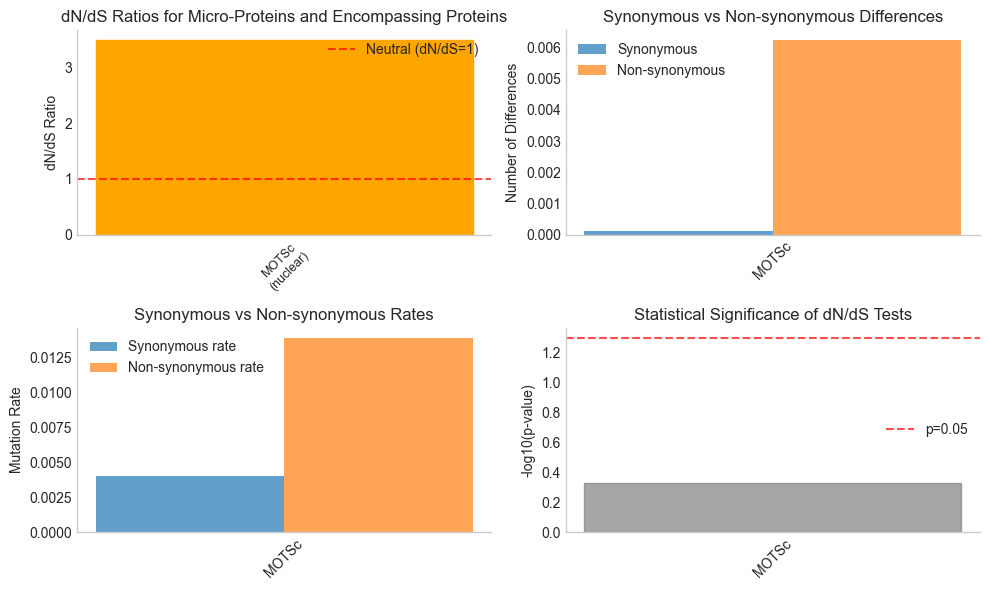

In [11]:
reload(mda)
# For RNR2 analysis
RNR1_MICROPROTEINS = [
    [695, 746, 'MOTSc', '+'],
]
# Define which genetic code each micro-protein uses
RNR1_GENETIC_CODES = {
    'MOTSc': 'nuclear',  # Translated in mitochondria

}

# Provide expected sequences for coordinate verification
RNR1_EXPECTED_SEQUENCES = {
}
# Run analysis with new features
results_rnr1 = mda.analyze_microprotein_dnds(
    df=hs_pop_df.dropna(subset=['RNR1']),
    microprotein_regions=RNR1_MICROPROTEINS,
    gene_name='RNR1',
    sequence_column='RNR1',
    expected_sequences=RNR1_EXPECTED_SEQUENCES,  # New!
    genetic_codes=RNR1_GENETIC_CODES,           # New!
    reference_sequence=ref_seq_rnr1,
    coordinate_search_window=50,                 # New!
    min_coordinate_similarity=0.8,              # New!
    plot_results=True,
    statistical_test = 'z_test_robust',
    output_file=os.path.join(PATH, 'figures', 'rnr1_dnds_analysis.png'),
    min_frequency = 1e-5,
    figsize = (10, 6),
    weight_by_frequency = True,
)

# Access amino acid sequences
for name, mp_result in results_rnr1['microprotein_results'].items():
    print(f"{name}: {mp_result['sequence_info']['amino_acid_sequence']}")
    print(f"Genetic code: {mp_result['sequence_info']['genetic_code']}")
    print(f"Coordinates adjusted: {mp_result['coordinates']['coordinate_adjusted']}")

In [12]:
ref_seq_ts2_tl2_nd5 = hs_pop_df[hs_pop_df['ID'] == 'NC_0129201']['TS2_TL2_ND5'].iloc[0]

2026-01-18 21:08:42,391 - INFO - Starting dN/dS analysis for TS2_TL2_ND5
2026-01-18 21:08:42,392 - INFO - Using Biopython method: NG86
2026-01-18 21:08:42,392 - INFO - Analyzing 1 micro-protein regions
2026-01-18 21:08:42,393 - INFO - Dataset contains 66271 sequences
2026-01-18 21:08:42,393 - INFO - Within protein mode: False
2026-01-18 21:08:42,395 - WARNING - Column 'TS2_TL2_ND5_seq' not found in DataFrame. Using TS2_TL2_ND5 as gene sequences.
2026-01-18 21:08:42,396 - INFO - Using provided reference sequence
2026-01-18 21:08:42,396 - WARNING - No reference gene sequence provided, using reference sequence for gene analysis
2026-01-18 21:08:42,396 - INFO - Subsampled from 66271 to 66271 sequences
2026-01-18 21:08:42,397 - INFO - Analyzing micro-protein: SHMOOSE (27-204, strand: +)
2026-01-18 21:08:42,397 - INFO - Using nuclear genetic code for SHMOOSE
2026-01-18 21:08:42,398 - INFO - Extracted reference sequence for SHMOOSE: ATGCCCCCATGTCTAACAACATGGCTTTCTCAACTTTTAAAGGATAACAGCTATCCATTG

Using 66271 sequences for gene TS2_TL2_ND5


2026-01-18 21:08:47,138 - INFO - out of 66271 sequences, 65955 were kept after cleaning for SHMOOSE
2026-01-18 21:08:47,138 - INFO - out of 59 codon positions, 59 were kept after cleaning for SHMOOSE
2026-01-18 21:08:47,142 - INFO - Found 268 unique variants for SHMOOSE after filtering
2026-01-18 21:08:47,775 - INFO - Total synonymous sites for SHMOOSE: 3.3517263454038515
2026-01-18 21:08:47,775 - INFO - Total non-synonymous sites for SHMOOSE: 44.32059569234913
2026-01-18 21:08:47,776 - INFO - Total synonymous differences for SHMOOSE: 0.05674031443624266
2026-01-18 21:08:47,776 - INFO - Total non-synonymous differences for SHMOOSE: 0.2937303628843931
2026-01-18 21:08:47,777 - INFO - Synonymous rate for SHMOOSE: 0.016929
2026-01-18 21:08:47,777 - INFO - Non-synonymous rate for SHMOOSE: 0.006627
2026-01-18 21:08:47,778 - INFO -   dN/dS ratio for SHMOOSE: 0.3915
2026-01-18 21:08:47,778 - INFO -   Synonymous rate: 0.016929
2026-01-18 21:08:47,779 - INFO -   Non-synonymous rate: 0.006627
20

SHMOOSE: MPPCLTTWLSQLLKDNSYPLVLGPKNFGATPNKSNNHAHYYNHPNPDFPNSPHPYHPR*
Genetic code: nuclear
Coordinates adjusted: False


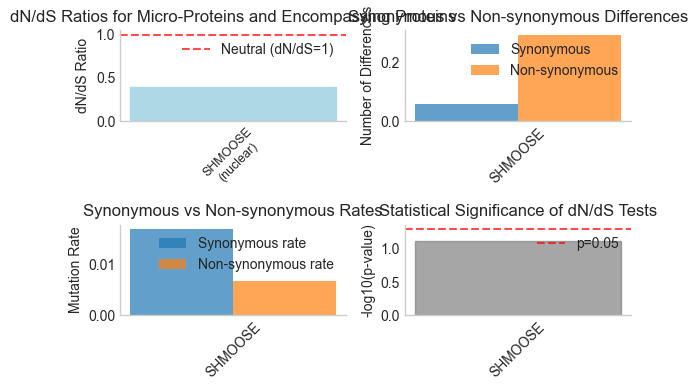

In [13]:
reload(mda)
# For shmoose analysis
SHMOOSE_MICROPROTEINS = [
    [27, 204, 'SHMOOSE', '+'],
]
# Define which genetic code each micro-protein uses
SHMOOSE_GENETIC_CODES = {
    'SHMOOSE': 'nuclear',  # Translated in mitochondria

}

# Provide expected sequences for coordinate verification
SHMOOSE_EXPECTED_SEQUENCES = {
}
# Run analysis with new features
results_shmoose = mda.analyze_microprotein_dnds(
    df=hs_pop_df.dropna(subset=['TS2_TL2_ND5']),
    microprotein_regions=SHMOOSE_MICROPROTEINS,
    gene_name='TS2_TL2_ND5',
    sequence_column='TS2_TL2_ND5',
    expected_sequences=SHMOOSE_EXPECTED_SEQUENCES,  # New!
    genetic_codes=SHMOOSE_GENETIC_CODES,           # New!
    coordinate_search_window=50,                 # New!
    reference_sequence=ref_seq_ts2_tl2_nd5,
    min_coordinate_similarity=0.8,              # New!
    plot_results=True,
    statistical_test = 'z_test_robust',
    output_file=os.path.join(PATH, 'figures', 'shmoose_dnds_analysis.png'),
    min_frequency = 1e-5,
    figsize = (6, 4),
    weight_by_frequency = True,
)

# Access amino acid sequences
for name, mp_result in results_shmoose['microprotein_results'].items():
    print(f"{name}: {mp_result['sequence_info']['amino_acid_sequence']}")
    print(f"Genetic code: {mp_result['sequence_info']['genetic_code']}")
    print(f"Coordinates adjusted: {mp_result['coordinates']['coordinate_adjusted']}")

In [14]:
nad4_overlaps_rel

[['ALTND4', 797, 1097]]

In [15]:
results_df_mdps = pd.concat([results_rnr1['results_df'], results_rnr2['results_df']])
results_df_mdps.to_csv(os.path.join(PATH, 'data', 'mdps_dnds_results.csv'))

# Combine all results into a single DataFrame
all_results_df = pd.concat([
    results_rnr1['results_df'],
    results_rnr2['results_df'],
    results_shmoose['results_df'],
], ignore_index=True)
# Save the combined results DataFrame to a CSV file
all_results_df.to_csv(os.path.join(PATH, 'data', 'all_mdps_alts_dnds_results.csv'), index=False)

2026-01-18 21:08:48,265 - INFO - Creating combined plot for 3 gene analyses
2026-01-18 21:08:48,302 - INFO - Plotting 9 items from 3 genes
2026-01-18 21:08:48,647 - INFO - Combined plot saved to c:\Users\shtolz\Desktop\multi_function_review\2025_mtdna_overlap_project\figures\combined_microprotein_analysis_mdps.png


Gene MicroProtein  AbsoluteStart  AbsoluteEnd Strand GeneticCode  \
0         RNR1        MOTSc            695          746      +     nuclear   
1         RNR2          Hum            962         1037      +     nuclear   
2         RNR2        SHLP1            814          889      -     nuclear   
3         RNR2        SHLP2            417          498      -     nuclear   
4         RNR2        SHLP3             32          149      -     nuclear   
5         RNR2        SHLP4            771          852      -     nuclear   
6         RNR2        SHLP5           1109         1184      -     nuclear   
7         RNR2        SHLP6           1319         1382      +     nuclear   
8  TS2_TL2_ND5      SHMOOSE             27          204      +     nuclear   

   Length                                  AminoAcidSequence  UniqueVariants  \
0      51                                  MRWQEMGYIFYPRKLR*              31   
1      75                          MAPRGFSCLLLLTSEIDLPVKRRA*              37   
2      75                          MCHWAGGASNTGDARGDVFGKQAG*              21   
3      81                        MGVKFFTLSTRFFPSVQRAVPLWTNS*              40   
4     117            MLGYNFSSFPCGTISIAPGFNFYRLYFIWVNGLAKVVW*             130   
5      81                        MLEVMFLVNRRGKICRVPFTFFNLSL*              18   
6      75                          MYCSEVGFCSEVAPTEIFNAGLVV*              40   
7      63                              MLDQDIPMVQPLLKVRLFND*              11   
8     177  MPPCLTTWLSQLLKDNSYPLVLGPKNFGATPNKSNNHAHYYNHPNP...             268   

   dN_dS_Ratio  SynonymousRate  NonsynonymousRate  Statistic   P_Value  \
0     3.496491        0.003971           0.013885   0.729176  0.465894   
1     2.188281        0.000058           0.000126   1.707901  0.204527   
2     1.257501        0.009954           0.012517   0.119281  0.905053   
3     3.939642        0.003897           0.015352   0.926197  0.496081   
4     0.152403        0.026279           0.004005  -2.535544  0.039296   
5     1.798159        0.002331           0.004191   0.353844  0.844032   
6     0.164954        0.040112           0.006617  -1.333107  0.319369   
7     0.015118        0.085445           0.001292  -4.262139  0.000142   
8     0.391489        0.016929           0.006627  -1.766177  0.077366   

   Is_Significant    Test_Method  IsValid ValidationIssues  CoordinateAdjusted  
0           False  Robust Z-test     True                                False  
1           False  Robust Z-test     True                                False  
2           False  Robust Z-test     True                                False  
3           False  Robust Z-test     True                                False  
4            True  Robust Z-test     True                                False  
5           False  Robust Z-test     True                                False  
6           False  Robust Z-test     True                                False  
7            True  Robust Z-test     True                                False  
8           False  Robust Z-test     True                                False

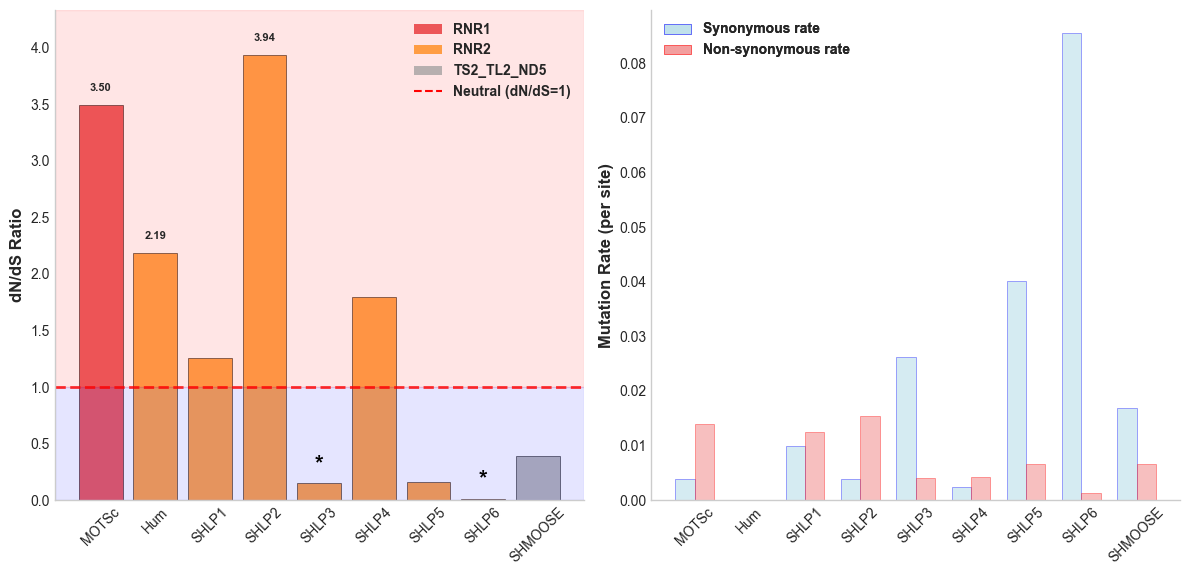

In [16]:
reload(mda)
# Create combined plot
combined_results_mdps = {
    'RNR1': results_rnr1,
    'RNR2': results_rnr2,
    'TS2_TL2_ND5': results_shmoose,
}

summary_table_mdps = mda.create_summary_table(combined_results_mdps)
mda.plot_combined_microprotein_analysis(
    results_dict=combined_results_mdps,
    output_file=os.path.join(PATH, 'figures', 'combined_microprotein_analysis_mdps.png'),
    title='',
    figsize=(12, 6),
    show_genetic_codes=True,
    show_gene_labels=True,
    display_summary_text=False,
    include_encompassing_proteins = False,
    legend_outside = False,
)
display(summary_table_mdps)

In [17]:
# for rnr2_overlaps_rel, rnr1_overlaps_rel, gau_overlaps_rel and shmoose_overlaps_rel, convert the structure from [[name, start, end], ...] to [[start, end, name, strand], ...]
rnr2_overlaps_rel_structured = []
for overlap in rnr2_overlaps_rel:
    rnr2_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+' if overlap[0] == 'Hum' or overlap[0] == 'SHLP6' else '-'])
rnr1_overlaps_rel_structured = []
for overlap in rnr1_overlaps_rel:
    rnr1_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+'])  
gau_overlaps_rel_structured = []
for overlap in gau_overlaps_rel:
    gau_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '-'])
shmoose_overlaps_rel_structured = []
for overlap in shmoose_overlaps_rel:
    shmoose_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+'])
co1_overlaps_rel_structured = []
for overlap in co1_overlaps_rel:
    co1_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+'])
nad4_overlaps_rel_structured = []
for overlap in nad4_overlaps_rel:
    nad4_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+'])
cyb_overlaps_rel_structured = []
for overlap in cyb_overlaps_rel:
    cyb_overlaps_rel_structured.append([overlap[1], overlap[2], overlap[0], '+'])

2026-01-18 21:08:48,919 - INFO - Applied reverse complement for SHLP3 (32-149)
2026-01-18 21:08:48,919 - INFO - Extracted 64933 sequences for SHLP3 (32-149) 
2026-01-18 21:08:48,985 - INFO - Applied reverse complement for SHLP2 (417-498)
2026-01-18 21:08:48,985 - INFO - Extracted 64933 sequences for SHLP2 (417-498) 
2026-01-18 21:08:49,052 - INFO - Applied reverse complement for SHLP4 (771-852)
2026-01-18 21:08:49,053 - INFO - Extracted 64933 sequences for SHLP4 (771-852) 
2026-01-18 21:08:49,117 - INFO - Applied reverse complement for SHLP1 (814-889)
2026-01-18 21:08:49,118 - INFO - Extracted 64933 sequences for SHLP1 (814-889) 
2026-01-18 21:08:49,134 - INFO - Extracted 64933 sequences for Hum (962-1037) 
2026-01-18 21:08:49,207 - INFO - Applied reverse complement for SHLP5 (1109-1184)
2026-01-18 21:08:49,207 - INFO - Extracted 64933 sequences for SHLP5 (1109-1184) 
2026-01-18 21:08:49,226 - INFO - Extracted 64933 sequences for SHLP6 (1319-1382) 
2026-01-18 21:08:49,246 - INFO - Extr

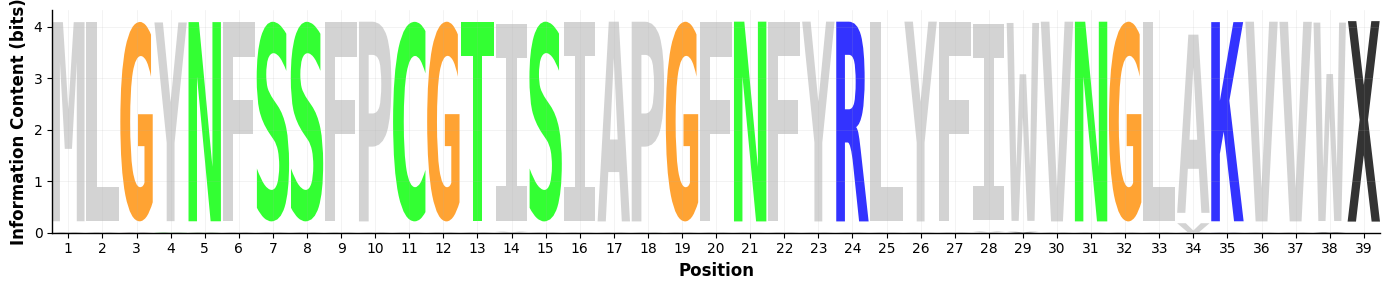

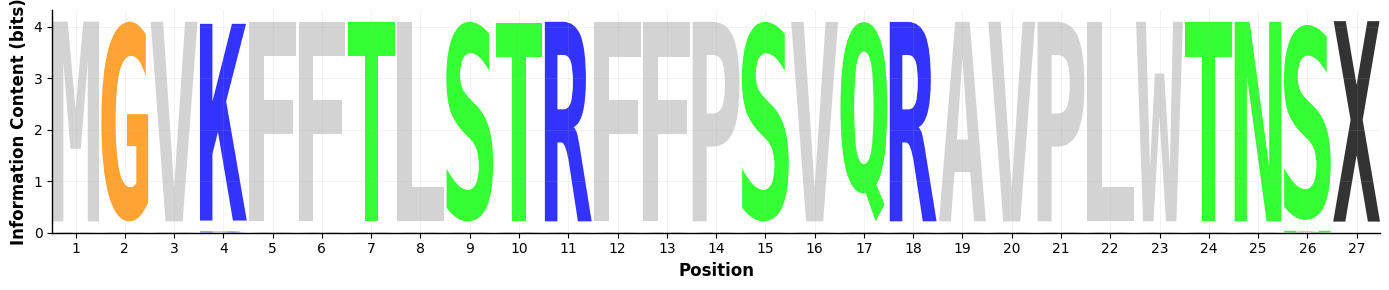

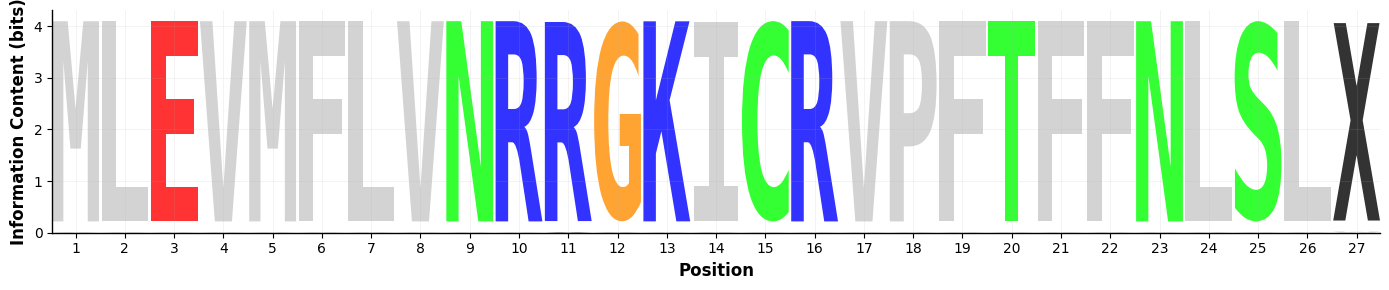

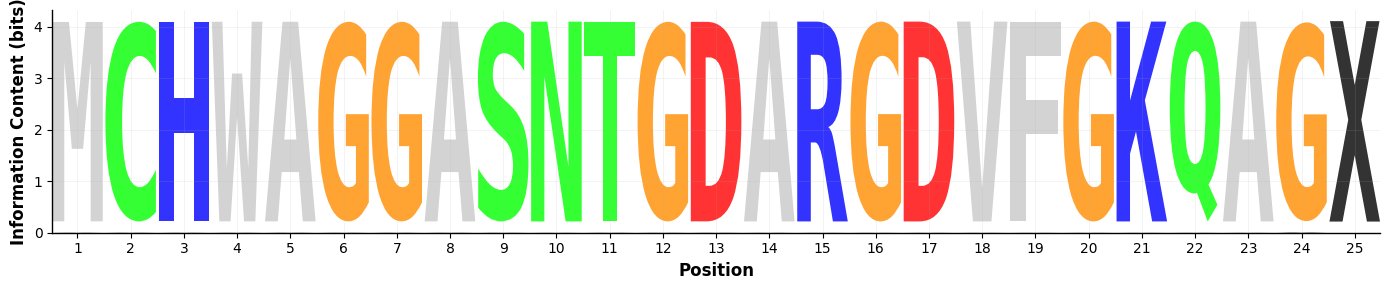

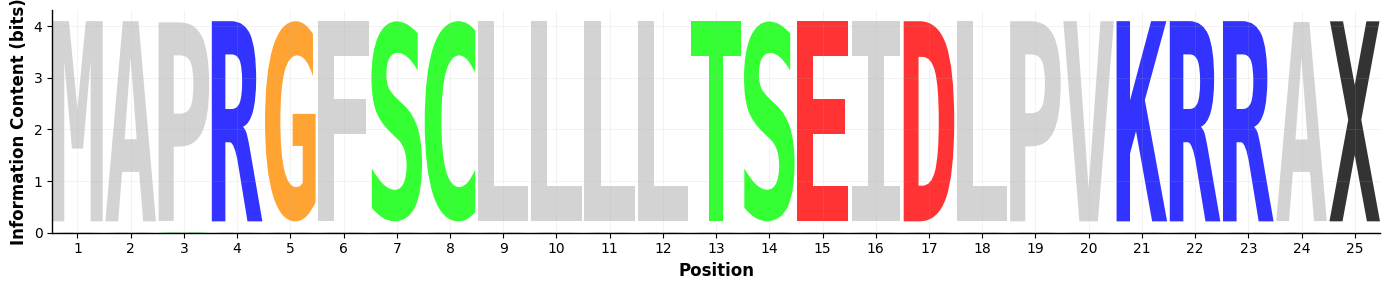

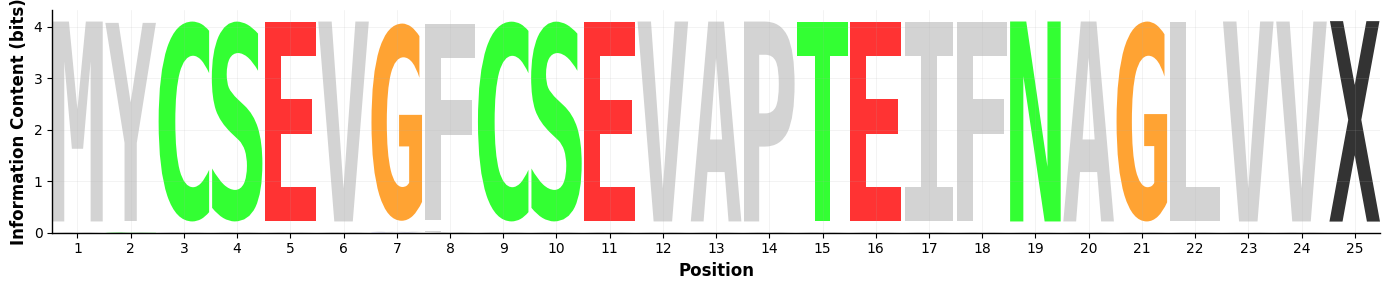

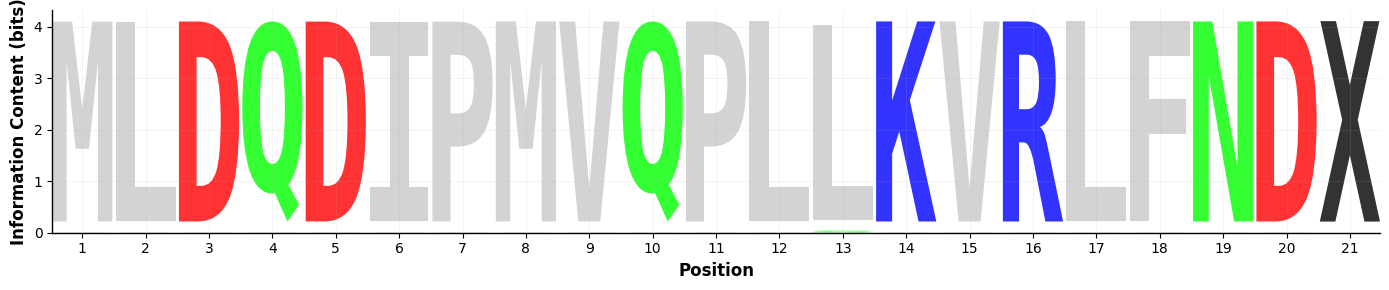

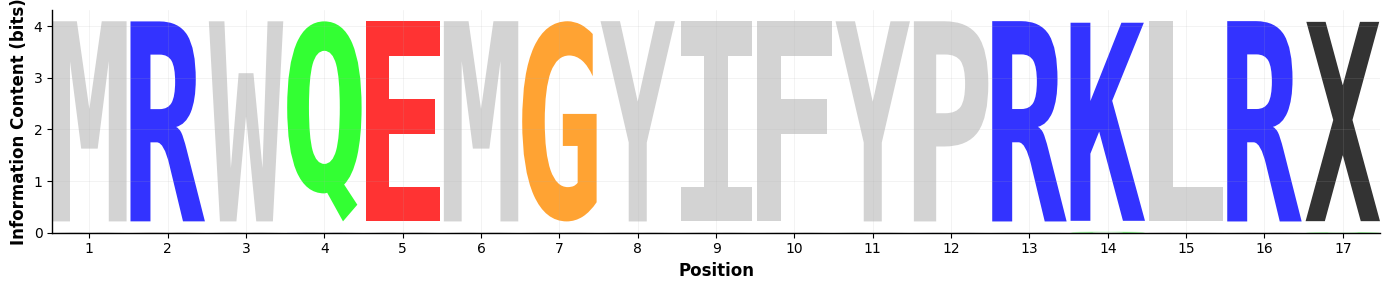

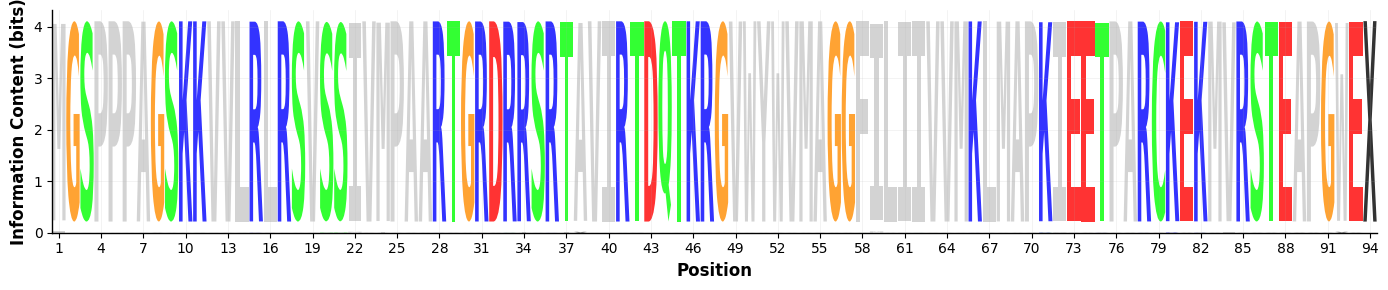

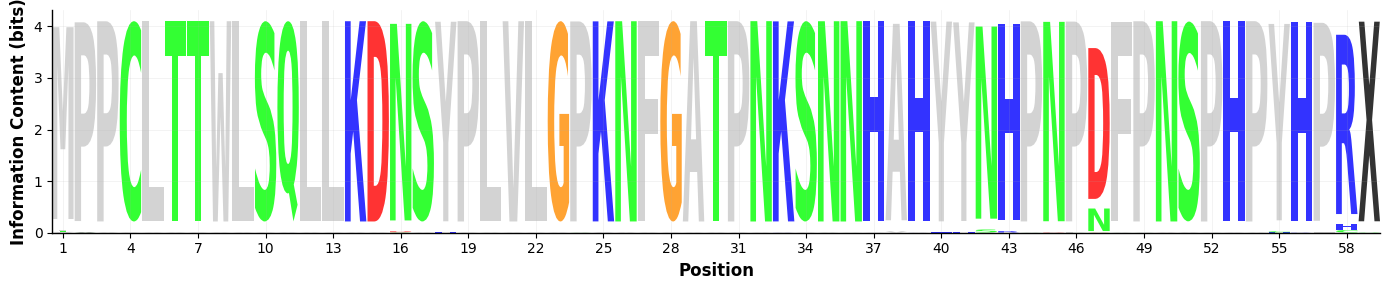

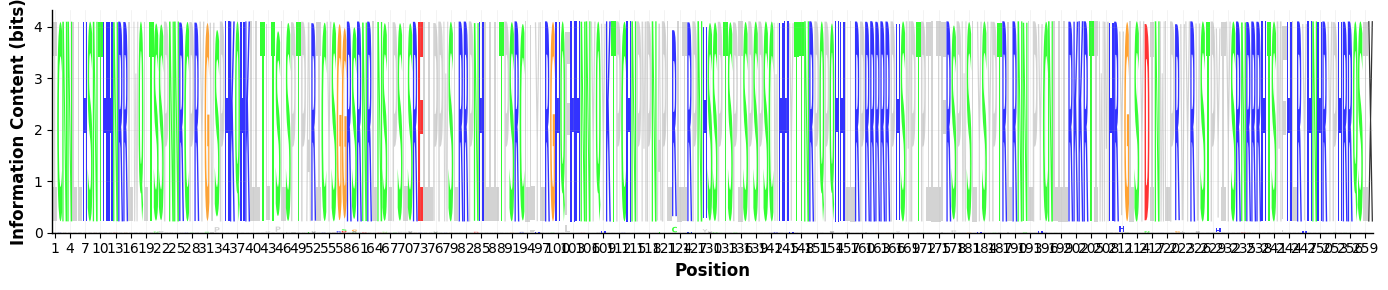

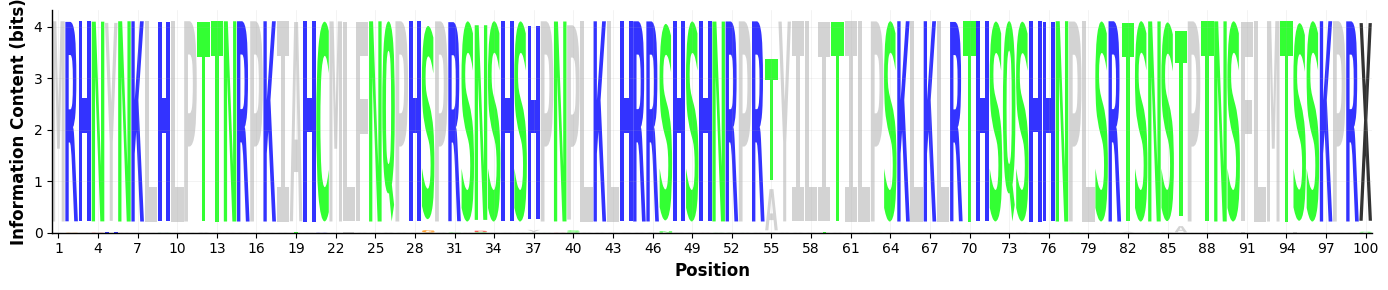

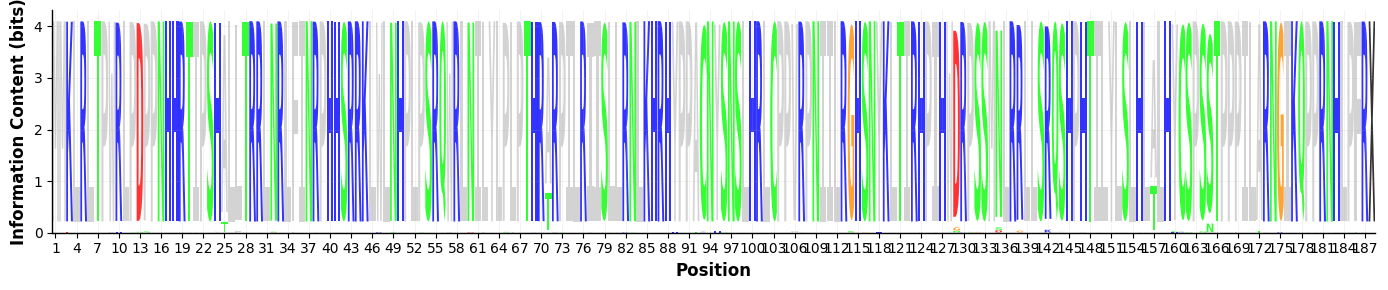

In [18]:
# Generate sequence dicts 
reload(slc)
sequences_dict_rnr2 = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='RNR2',
    microprotein_regions=rnr2_overlaps_rel_structured,
)
sequences_dict_rnr1 = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='RNR1',
    microprotein_regions=rnr1_overlaps_rel_structured,
)
sequences_dict_gau = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='COX1',
    microprotein_regions=gau_overlaps_rel_structured,
)
sequences_dict_shmoose = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='TS2_TL2_ND5',
    microprotein_regions=shmoose_overlaps_rel_structured,
)
sequences_dict_co1_alt = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='COX1',
    microprotein_regions=co1_overlaps_rel_structured,
)
sequences_dict_nd4_alt = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='ND4',
    microprotein_regions=nad4_overlaps_rel_structured,
)
sequences_dict_cyb_alt = slc.extract_microprotein_sequences(
    dataframe=hs_pop_df,
    sequence_column='CYTB', 
    microprotein_regions=cyb_overlaps_rel_structured,
)
# Combine all sequences into a single dict
sequences_dict = {**sequences_dict_rnr2, **sequences_dict_rnr1, **sequences_dict_gau, **sequences_dict_shmoose, **sequences_dict_co1_alt, **sequences_dict_nd4_alt, **sequences_dict_cyb_alt}
# Create all logos
logo_results, logo_summary = slc.create_multiple_sequence_logos(
    sequences_dict=sequences_dict,
    genetic_codes={'MOTS-c': 'nuclear', 'Hum': 'nuclear', 'SHLP1': 'nuclear', 'SHLP2': 'nuclear', 'SHLP3': 'nuclear', 'SHLP4': 'nuclear', 'SHLP5': 'nuclear', 'SHLP6': 'nuclear', 'SHMOOSE': 'nuclear', 'GAU': 'nuclear',
                   'ALTCO1': 'mitochondrial', 'ALTND4': 'mitochondrial', 'CYTB-187AA': 'nuclear'},
    output_dir=os.path.join(PATH, 'figures','sequence_logos', 'all_microproteins_sequence_logos'),
    color_scheme='NajafabadiEtAl2017',
    figsize=(14, 3),
    min_frequency=0.00001,
    information_box = False,
    show_conservation = False,
    title = '',
    statistical_test = True,
    n_permutations = 100,
)



In [19]:
logo_results

{'SHLP3': {'microprotein_name': 'SHLP3',
  'n_sequences': 64933,
  'sequence_length': 39,
  'genetic_code': 'nuclear',
  'strand': '+',
  'position_frequencies': [{'M': 0.9981519412317311,
    'V': 0.0006622210586296644,
    'X': 0.001170437219903593,
    'I': 1.5400489735573592e-05},
   {'L': 0.9987679608211542,
    'X': 0.0011858377096391666,
    'F': 1.5400489735573592e-05,
    'P': 3.0800979471147184e-05},
   {'G': 0.9985061524956493,
    'X': 0.0013860440762016233,
    'D': 9.240293841344155e-05,
    'R': 1.5400489735573592e-05},
   {'Y': 0.9976129240909861,
    'X': 0.0011858377096391666,
    'C': 0.001093434771225725,
    'H': 9.240293841344155e-05,
    'N': 1.5400489735573592e-05},
   {'N': 0.9982597446598802,
    'X': 0.0011396362404324457,
    'S': 0.0005544176304806493,
    'D': 4.620146920672077e-05},
   {'F': 0.9984907520059138,
    'X': 0.0011396362404324457,
    'L': 0.0003696117536537662},
   {'S': 0.998844963269832, 'X': 0.0011550367301680193},
   {'S': 0.9987987618006

Heatmap summary saved to c:\Users\shtolz\Desktop\multi_function_review\2025_mtdna_overlap_project\figures\mdp_heatmap_summary.png


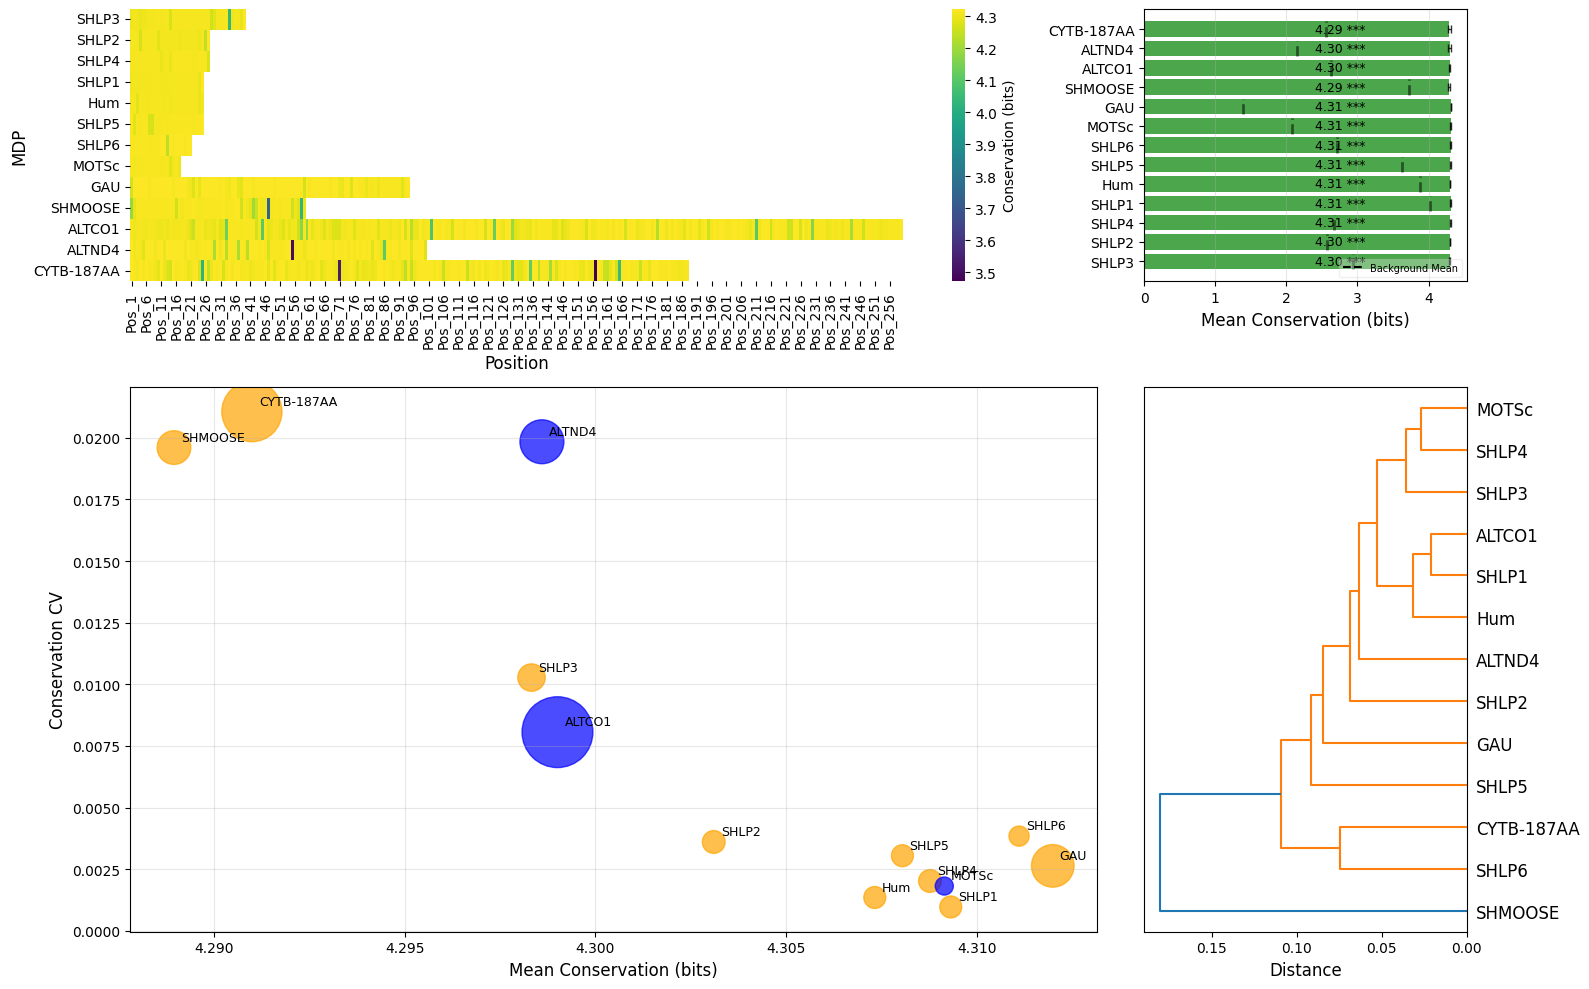

In [20]:
reload(slc)
summary_logo = slc.create_mdp_heatmap_summary(logo_results, output_file = os.path.join(PATH, 'figures', 'mdp_heatmap_summary.png'))